# Подготовка библиотек и данных



1) Для каких рядов не будет работать SARIMA:
Модель SARIMA (сезонная ARIMA) предназначена для работы с временными рядами, у которых есть явные сезонные паттерны. Однако она не будет эффективна для:

Непериодических рядов: Если временной ряд не имеет сезонности (например, случайные колебания без видимого шаблона), SARIMA может оказаться излишне сложной и не даст хороших результатов.
Сильно нестационарных рядов: Если ряд имеет тренд, который не периодически колеблется или не может быть устранён при помощи интерграции, SARIMA может не подойти.
Рядов с малым количеством наблюдений: Если имеется недостаточно данных для выявления сезонных паттернов, модель также не будет эффективной.
Ряды с отсутствующими или нерегулярными данными: Если в данных есть много пробелов, это может привести к проблемам с оценкой сезонных компонентов.

2) Проблемы с исходными данными, если не учитывать пропуски и дубликаты:
Даже если данные кажутся корректными, игнорирование пропусков и дубликатов может привести к нескольким проблемам:

Искажение результатов: Пропуски и дубликаты могут привести к неправильным оценкам параметров модели, что повлияет на точность прогнозов.
Снижение качества модели: Если пропуски не представлены в ходе анализа, это может сильнее исказить данные и привести к неверным выводам.
Ошибки во временных метках: Если дубликаты возникают в данных по временным меткам, это может создать ложные тренды или сезонности.
Проблемы с интерпретацией результатов: Неправильные данные могут привести к неадекватной интерпретации модели и её результатов, что затруднит принятие решений на основе этой информации.

In [59]:
# ip3 install pandas numpy matplotlib statsmodels - если не установлены
#импорт необходимых библиотек
import warnings
import itertools


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import calendar


global_date = 'Month'
global_source = 'Passengers'


In [60]:
#Загрузка данных
# для локального файла time_series = pd.read_csv('airline_passengers.csv')
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
time_series_inp = pd.read_csv(url, encoding='latin1', sep=',', decimal='.') # utf-8 Windows-1252

In [61]:
#просмотр набора начало(голова)
print(time_series_inp.head())

     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121


In [62]:
#просомтр набора окончание (хвост)
print(time_series_inp.tail())

       Month  Passengers
139  1960-08         606
140  1960-09         508
141  1960-10         461
142  1960-11         390
143  1960-12         432


# Обработка данных

In [63]:
print(time_series_inp.head())
time_series=time_series_inp
#time_series = time_series_inp[[global_date,global_source]]
#time_series.dtypes
print(time_series.columns)
time_series[global_date] = pd.to_datetime(time_series[global_date])


     Month  Passengers
0  1949-01         112
1  1949-02         118
2  1949-03         132
3  1949-04         129
4  1949-05         121
Index(['Month', 'Passengers'], dtype='object')


In [64]:
#проверка пропущенных значений
print(time_series.isnull().sum())

Month         0
Passengers    0
dtype: int64


In [65]:
#В случае обнаружения пропуском их можно заполнить например средними значениями или медианой
# time_series = time_series.fillna(time_series.median())
# Для замены только в конкретном столбце:
#time_series['Столбец 1'] = time_series['Столбец 1'].fillna(time_series['Столбец 1'].median())

In [66]:
#Доп обработка, частный случай
#time_series[global_source] = time_series[global_source].str.replace(',', '.', regex=True).str.strip()
#time_series[global_source] = pd.to_numeric(time_series[global_source], errors='coerce')
#time_series.dtypes
# Проверить наличие NaN



In [67]:
nan_count = time_series[global_source].isna().sum()
print(f"Количество NaN в {global_source}: {nan_count}")
# Проверить, какие значения не удалось преобразовать
invalid_sales = time_series[time_series[global_source].isna()]
print("Неверные значения в "+ global_source + ":")
print(invalid_sales)

Количество NaN в Passengers: 0
Неверные значения в Passengers:
Empty DataFrame
Columns: [Month, Passengers]
Index: []


In [68]:
time_series.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [69]:
#Проверка и преобразование типов данных
#df.column_name.dtype - для конкретного
#df.dtypes - для всех столбцов
#df.dtypes [df.dtypes=='int64'] - поиск конкретного типа

#преобразование данных в даты
time_series[global_date] = pd.to_datetime(time_series[global_date],format='%d.%m.%Y')
time_series.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [70]:
time_series = time_series.groupby(time_series[global_date].dt.date)[global_source].sum().reset_index()

In [71]:
# Просмотр графика с линией тренда
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_source_with_trend(time_series_inp):
    # Сбросить индекс и построить график разброса
    time_series = time_series_inp.copy()
    time_series.reset_index(inplace=True)
    plt.figure(figsize=(10, 6))
    plt.scatter(time_series[global_date], time_series[global_source], label=global_source, color='blue')

    # Преобразуем даты в числовой формат
    time_series['date_num'] = mdates.date2num(time_series[global_date])

    # Расчет коэффициентов для линейной регрессии
    z = np.polyfit(time_series['date_num'], time_series[global_source], 1)
    p = np.poly1d(z)

    # Добавить линию тренда
    plt.plot(time_series[global_date], p(time_series['date_num']), color='red', label='Trend Line')

    # Настройка графика
    plt.title('Sum of ' + global_source + ' Over Time with Trend Line')
    plt.xlabel(global_date)
    plt.ylabel('Sum of ' + global_source)
    plt.legend()

    plt.show()

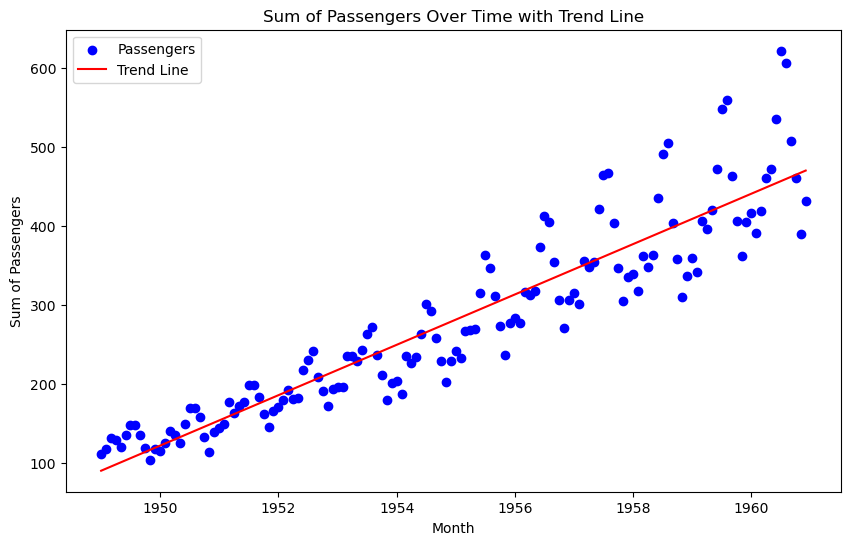

In [72]:
plot_source_with_trend(time_series)

In [73]:
#Изменение масштаба данных (нужно в случае если размах слишком велик
#print(time_series.columns)
#time_series.plot.scatter(x='Month', y='Passengers')

In [74]:
#Указание поля Month (DataTime) в качестве индекса. Удобно для работы с временными рядами.
#при установке индекса он пропадет из столбцов и станет индексом
time_series.set_index(global_date, inplace=True)

#Изменение масштаба данных (нужно в случае если размах слишком велик
# Пример стандартизации данных 
``` 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
time_series[['Passengers']] = scaler.fit_transform(time_series[['Passengers']])
```


In [75]:
"""
Пример стандартизации данных 
отброс мусорных данных Метод Чуи и Бокса (IQR):
Этот метод основан на интерквартильном размахе (IQR), который позволяет удалить выбросы, выходящие за пределы 1.5 * IQR от нижнего и верхнего квартиля.
"""
Q1 = time_series[global_source].quantile(0.25)
Q3 = time_series[global_source].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

time_series = time_series[(time_series[global_source] >= lower_bound) & (time_series[global_source] <= upper_bound)]

"""
Дополнительные способы
Z-оценка:
Можно также использовать Z-оценку, чтобы удалить выбросы на основе стандартного отклонения.
from scipy import stats

z_scores = np.abs(stats.zscore(time_series[sales]))
filtered_time_series = time_series[z_scores < 3]  # порог 3 — классический вариант

Логарифмическое преобразование:
Это может помочь уменьшить влияние выбросов
time_series[sales] = np.log1p(time_series[sales])  # log1p для обработки нулевых значений


"""





'\nДополнительные способы\nZ-оценка:\nМожно также использовать Z-оценку, чтобы удалить выбросы на основе стандартного отклонения.\nfrom scipy import stats\n\nz_scores = np.abs(stats.zscore(time_series[sales]))\nfiltered_time_series = time_series[z_scores < 3]  # порог 3 — классический вариант\n\nЛогарифмическое преобразование:\nЭто может помочь уменьшить влияние выбросов\ntime_series[sales] = np.log1p(time_series[sales])  # log1p для обработки нулевых значений\n\n\n'

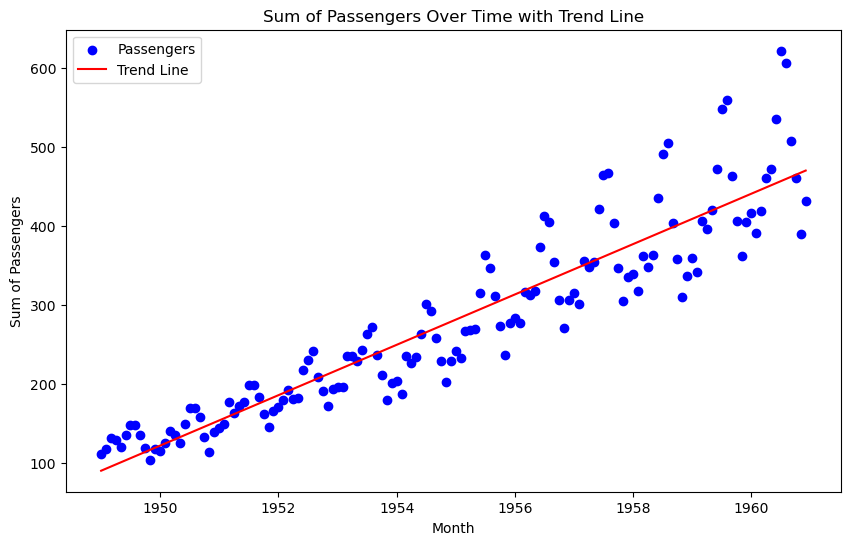

In [76]:
#Проверочный модуль.
plot_source_with_trend(time_series)


In [77]:
time_series.dtypes

Passengers    int64
dtype: object

In [78]:
#Cглаживание данных методом вейвлет-сглаживания
# pip install pywavelets pandas
"""
import pandas as pd
import pywt
import numpy as np


# Функция для вейвлет-сглаживания
def wavelet_smoothing(data, wavelet='db1', level=1):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Убираем высокочастотные компоненты
    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]
    smoothed_data = pywt.waverec(coeffs, wavelet)
    return smoothed_data

# Сглаживание данных
smoothed_data = wavelet_smoothing(time_series['sales'].values)
print(f"Original length: {len(time_series['sales'].values)}")
print(f"Smoothed length: {len(smoothed_data)}")

# Убедитесь, что длины совпадают
if len(smoothed_data) < len(time_series):
    smoothed_data = np.pad(smoothed_data, (0, len(time_series) - len(smoothed_data)), 'edge')
else:
    smoothed_data = smoothed_data[:len(time_series)]

time_series['sales'] = smoothed_data
plot_source_with_trend(time_series)
"""

'\nimport pandas as pd\nimport pywt\nimport numpy as np\n\n\n# Функция для вейвлет-сглаживания\ndef wavelet_smoothing(data, wavelet=\'db1\', level=1):\n    coeffs = pywt.wavedec(data, wavelet, level=level)\n    # Убираем высокочастотные компоненты\n    coeffs[1:] = [np.zeros_like(c) for c in coeffs[1:]]\n    smoothed_data = pywt.waverec(coeffs, wavelet)\n    return smoothed_data\n\n# Сглаживание данных\nsmoothed_data = wavelet_smoothing(time_series[\'sales\'].values)\nprint(f"Original length: {len(time_series[\'sales\'].values)}")\nprint(f"Smoothed length: {len(smoothed_data)}")\n\n# Убедитесь, что длины совпадают\nif len(smoothed_data) < len(time_series):\n    smoothed_data = np.pad(smoothed_data, (0, len(time_series) - len(smoothed_data)), \'edge\')\nelse:\n    smoothed_data = smoothed_data[:len(time_series)]\n\ntime_series[\'sales\'] = smoothed_data\nplot_source_with_trend(time_series)\n'

# Визуализация данных

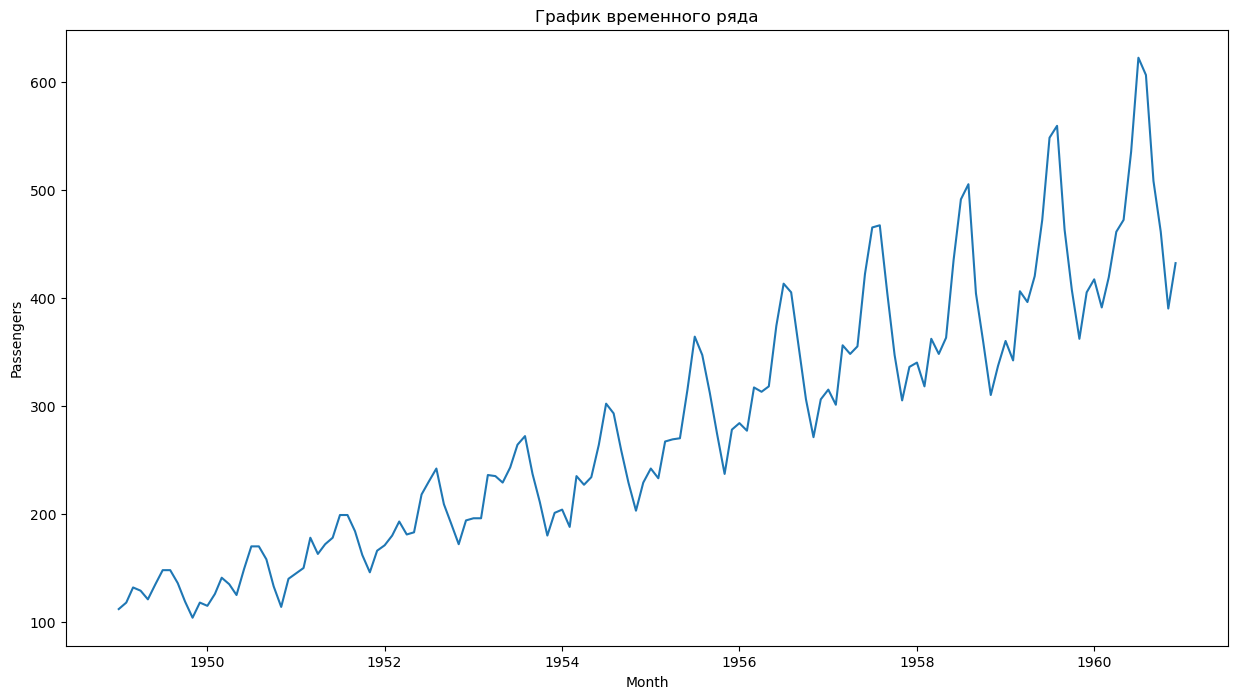

In [79]:
# Построение графика
plt.figure(figsize=(15,8))
plt.plot(time_series[global_source])
plt.title('График временного ряда')
plt.xlabel(global_date)
plt.ylabel(global_source)
plt.show()

In [80]:
#Оценка стационарности ряда тесто Дики-фуллера
from statsmodels.tsa.stattools import adfuller

def dik_full_test(time_series_ex):
    time_series = time_series_ex.copy()
    print('Результат теста:')
    df_result = adfuller(time_series[global_source])
    df_labels = ['ADF Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used']
    for result_value, label in zip(df_result, df_labels):
        print(label + ' : ' + str(result_value))
    
    if df_result[1] <= 0.05:
        print("Сильные доказательства против нулевой гипотезы, ряд является стационарным.")
    else:
        print("Слабые доказательства против нулевой гипотезы, ряд не является стационарным.")
# в случае не стационарности необходимо найти парамтеры для модели ARIMA для приведения к стационарности

### Способы приведения к стационарности
Дифференцирование: один из самых распространенных методов, именно с помощью дифференцирования ARIMA приводит ряд к стационарности. Этот процесс основывается на вычислении разницы между последовательными наблюдениями во временном ряду. 

Сезонное дифференцирование: вариация обычного дифференцирования, которая применяется для данных с сезонной компонентой

Логарифмирование: создание логарифма данных может помочь снизить вариативность ряда и сделать его более стационарным. 

In [81]:
dik_full_test(time_series)

Результат теста:
ADF Test Statistic : 0.8153688792060585
p-value : 0.9918802434376411
#Lags Used : 13
Number of Observations Used : 130
Слабые доказательства против нулевой гипотезы, ряд не является стационарным.


# Модель ARIMA
 ARIMA (AutoRegressive Integrated Moving Average), Авторегрессионное интегрированное скользящее среднее — это статистическая модель, которая используется для анализа и прогнозирования данных динамических рядов. 

1. Авторегрессионная (AR) часть относится к использованию зависимости между текущим наблюдением и определенным количеством предыдущих наблюдений. Например, чтобы предсказать погоду на завтра, мы смотрим погоду в предыдущие дни. 

2. Интегрированная (I) часть обозначает, что данные временного ряда преобразуются с целью сделать ряд стационарным. Под стационарностью подразумевается такое свойство временного ряда, при котором его статистические характеристики не меняются во времени. Например, среднее и дисперсия остаются постоянными со временем. Обычно это достигается путем применения операции разности к ряду один или несколько раз. 

3. Скользящее среднее (MA) относится к моделированию ошибки между реальным наблюдением и прогнозируемым значением, используя комбинацию значений ошибок предыдущих шагов. 

Модель ARIMA обычно обозначается как ARIMA (p, d, q), где p, d и q — параметры модели: 

p — порядок авторегрессии, который описывает количество предыдущих наблюдений, принимаемых во внимание в модели. 

d — порядок интегрирования, который указывает, сколько раз нужно взять разность временного ряда для достижения стационарности. 

q — порядок скользящего среднего, который связан с количеством предыдущих ошибок, используемых в модели.

Выбор подходящих значений (p, d, q) в модели ARIMA — это искусство и наука, требующая обращения с автокорреляционными и частными автокорреляционными графиками, а также применения информационных критериев. 

# Сезонная модель SARIMA
Сезонная модель ARIMA или SARIMA (Seasonal Autoregressive Integrated Moving Average) — это расширение модели ARIMA, добавляющее в нее понятие сезонности. В ряде ситуаций динамические ряды отражают явные сезонные колебания. Позволяет уловить сезонные колебания.

Сезонная модель ARIMA обычно обозначается как SARIMA (p, d, q) (P, D, Q) m, где p, d, q — это несезонные параметры, а P, D, Q — сезонные:

p, d, q работают также, как и в ARIMA.

P — порядок сезонной авторегрессии, и он основан на количестве предыдущих сезонов, которые влияют на текущий сезон.

D — порядок сезонной интеграции, то есть сколько раз нужно продифференцировать данные, чтобы убрать сезонные тренды.

Q — порядок сезонного скользящего среднего, то есть как много предыдущих сезонных ошибок прогноза используется в модели.

m — это длина сезонного периода. Например, если данные имеют годовую сезонность и данные собираются ежемесячно, то m будет равно 12. 

# Определение параметров модели
Для настройки используется поиск по сетке(grid search)
цель — найти баланс между временем, затраченным на «поиск по сетке», и качеством исходной модели, то есть найти такие значения параметров, при которых качество будет наибольшим, а затраты времени минимальными.

In [82]:
"""from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#игнорируем предупреждения о возможных проблемах или не оптимальности
warnings.filterwarnings("ignore")

#Создание диапазона параметров для настройки модели
def search_optimal_sarima(time_series, seasonal_cycle):
    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
       
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                sarima_model = sm.tsa.statespace.SARIMAX(time_series,
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)

                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except:
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 30
#search_optimal_sarima(time_series, seasonal_cycle_length)


#ARIMA(0, 0, 1)x(0, 1, 1, 30) - AIC:20549.695262919155 10m 56s рассчет"""

'from statsmodels.tsa.arima.model import ARIMA\nfrom statsmodels.tsa.stattools import acf, pacf\nfrom statsmodels.graphics.tsaplots import plot_acf, plot_pacf\n\n#игнорируем предупреждения о возможных проблемах или не оптимальности\nwarnings.filterwarnings("ignore")\n\n#Создание диапазона параметров для настройки модели\ndef search_optimal_sarima(time_series, seasonal_cycle):\n    order_vals = diff_vals = ma_vals = range(0, 2)\n    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))\n    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]\n       \n    smallest_aic = float("inf")\n    optimal_order_param = optimal_seasonal_param = None\n\n    for order_param in pdq_combinations:\n        for seasonal_param in seasonal_combinations:\n            try:\n                sarima_model = sm.tsa.statespace.SARIMAX(time_series,\n                                                         order=order_param,\n                 

In [83]:
# ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:920.3192974989254 - пример рассчитанного значения для настройки нашей модели.

In [84]:
"""import itertools
import cupy as cp
import statsmodels.api as sm

def search_optimal_sarima(time_series, seasonal_cycle):
    # Перенос данных на GPU с CuPy
    warnings.filterwarnings("ignore")
    time_series_gpu = cp.asarray(time_series)

    order_vals = diff_vals = ma_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]
       
    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    for order_param in pdq_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                # Преобразуем обратно в NumPy для statsmodels
                sarima_model = sm.tsa.statespace.SARIMAX(cp.asnumpy(time_series_gpu),
                                                         order=order_param,
                                                         seasonal_order=seasonal_param,
                                                         enforce_stationarity=False,
                                                         enforce_invertibility=False)

                model_results = sarima_model.fit()
                if model_results.aic < smallest_aic:
                    smallest_aic = model_results.aic
                    optimal_order_param = order_param
                    optimal_seasonal_param = seasonal_param
            except Exception as e:
                # Добавлено для отладки ошибок
                print(f"Error for order_param {order_param} and seasonal_param {seasonal_param}: {e}")
                continue

    print('ARIMA{}x{} - AIC:{}'.format(optimal_order_param, optimal_seasonal_param, smallest_aic))

seasonal_cycle_length = 30
# Пример использования
# Вольный пример данных
search_optimal_sarima(time_series, seasonal_cycle_length)"""


'import itertools\nimport cupy as cp\nimport statsmodels.api as sm\n\ndef search_optimal_sarima(time_series, seasonal_cycle):\n    # Перенос данных на GPU с CuPy\n    warnings.filterwarnings("ignore")\n    time_series_gpu = cp.asarray(time_series)\n\n    order_vals = diff_vals = ma_vals = range(0, 2)\n    pdq_combinations = list(itertools.product(order_vals, diff_vals, ma_vals))\n    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]\n       \n    smallest_aic = float("inf")\n    optimal_order_param = optimal_seasonal_param = None\n\n    for order_param in pdq_combinations:\n        for seasonal_param in seasonal_combinations:\n            try:\n                # Преобразуем обратно в NumPy для statsmodels\n                sarima_model = sm.tsa.statespace.SARIMAX(cp.asnumpy(time_series_gpu),\n                                                         order=order_param,\n                                                         seasonal_o

In [85]:
import tensorflow as tf

def check_tensor_shape(data):
    """
    Функция для проверки и анализа размерности тензора.
    
    Аргументы:
    - data: Входные данные, которые могут быть списком, numpy массивом или другим типом данных, который можно преобразовать в тензор.

    Возвращает:
    - Размерность тензора.
    """
    tensor = tf.convert_to_tensor(data, dtype=tf.float32)
    shape = tensor.shape
    print(f"Размерность тензора: {shape}")
    
    if len(shape) != 2:
        print("Предупреждение: Тензор имеет неправильное количество измерений (ожидалось 2 измерения).")
    
    if shape[1] != 1:
        print("Предупреждение: Второе измерение тензора не равно 1, что может вызвать ошибки в модели.")
    
    return shape

# Пример использования
# Замените на ваши данные
example_data = time_series 
check_tensor_shape(example_data)

Размерность тензора: (144, 1)


TensorShape([144, 1])

In [91]:
import tensorflow as tf
import itertools
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm

global_optimal_order_param = (0, 0, 0) #default
global_optimal_seasonal_param = (0, 0, 0, 9) #default

def compute_aic(n, rss, k):
    return n * tf.math.log(rss / n) + 2 * k

def difference(ts, n=1):
    if n <= 0:
        return ts
    diff_ts = ts[n:] - ts[:-n]
    return diff_ts

def arima_tensorflow(time_series, order, seasonal_order, seasonal_cycle):
    p, d, q = order
    P, D, Q, S = seasonal_order

    # Input validation
    if time_series.shape[0] == 0:
        print("Time series is empty.")
        return float("inf")

    # Differencing
    ts_diff = time_series
    if d > 0:
        ts_diff = difference(ts_diff, n=d)

    # Seasonal differencing
    if D > 0:
        ts_diff = difference(ts_diff, n=seasonal_cycle)

    n = ts_diff.shape[0]
    max_lag = max(p, q)

    if n <= max_lag:
        print(f"Недостаточно данных для p={p} и q={q}. n = {n}")
        return float("inf")

    # AR and MA terms
    X_ar = tf.concat([tf.roll(ts_diff, shift=i, axis=0)[max_lag:] for i in range(1, p + 1)], axis=1) if p > 0 else tf.zeros((n - max_lag, 0))
    X_ma = tf.concat([tf.roll(ts_diff, shift=i, axis=0)[max_lag:] for i in range(1, q + 1)], axis=1) if q > 0 else tf.zeros((n - max_lag, 0))

    # Create design matrix X
    if X_ar.shape[1] == 0 and X_ma.shape[1] == 0:
        X = tf.ones((n - max_lag, 1))  # Ensure X is 2D
    else:
        X = tf.concat([X_ar, X_ma], axis=1)

    # Create response vector y
    y = ts_diff[max_lag:]
    y = tf.reshape(y, (-1, 1))  # Ensure y is shaped as (n - max_lag, 1)

    # Shape checks
    if X.shape[0] != y.shape[0]:
        print(f"Shape mismatch: X.shape = {X.shape}, y.shape = {y.shape}")
        return float("inf")

    # Ensure shapes are appropriate
    if X.shape[1] == 0 or y.shape[0] == 0:
        print("No valid features or response variable.")
        return float("inf")

    # Fit model
    try:
        beta = tf.linalg.lstsq(X, y, fast=False)
        beta = tf.reshape(beta, (-1, 1))  # Ensure beta is shaped as (k, 1)

    except Exception as e:
        print(f"Error during matrix solve: {e}. X shape: {X.shape}, y shape: {y.shape}")
        return float("inf")

    # Prediction and residual calculation
    y_pred = tf.matmul(X, beta)
    residuals = y - y_pred  # Ensure shapes align
    rss = tf.reduce_sum(tf.square(residuals))

    if rss < 1e-10:  # Check for near-zero RSS
        print("RSS is non-positive.")
        return float("inf")

    aic = compute_aic(n, rss, p + q + 1)  # Adjust if including seasonal parameters

    return aic

def search_optimal_sarima(time_series, seasonal_cycle, max_workers=4):
    global global_optimal_order_param
    global global_optimal_seasonal_param
    time_series_tensor = tf.convert_to_tensor(time_series, dtype=tf.float32)

    order_vals = range(0, 2)
    pdq_combinations = list(itertools.product(order_vals, order_vals, order_vals))
    seasonal_combinations = [(combo[0], combo[1], combo[2], seasonal_cycle) for combo in pdq_combinations]

    smallest_aic = float("inf")
    optimal_order_param = optimal_seasonal_param = None

    def evaluate_combination(order_param, seasonal_param):
        try:
            aic = arima_tensorflow(time_series_tensor, order_param, seasonal_param, seasonal_cycle)
            return (aic, order_param, seasonal_param)
        except Exception as e:
            print(f"Error for order_param {order_param} and seasonal_param {seasonal_param}: {e}")
            return (float("inf"), order_param, seasonal_param)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(lambda params: evaluate_combination(*params), itertools.product(pdq_combinations, seasonal_combinations)),
                             total=len(pdq_combinations) * len(seasonal_combinations), desc='Evaluating combinations'))

    for aic, order_param, seasonal_param in results:
        if aic < smallest_aic:
            smallest_aic = aic
            optimal_order_param = order_param
            global_optimal_order_param = optimal_order_param
            optimal_seasonal_param  = seasonal_param
            global_optimal_seasonal_param = seasonal_param

    print(f'ARIMA{optimal_order_param}x{optimal_seasonal_param} - AIC:{smallest_aic}')

# Example usage
seasonal_cycle_length = 12
# Ensure time_series is defined before calling the function
# time_series = ... (your time series data)
search_optimal_sarima(time_series, seasonal_cycle_length)


Evaluating combinations: 100%|██████████| 64/64 [00:00<00:00, 630.37it/s]

ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:648.3666381835938


In [29]:
time_series.index

Index([2015-01-03, 2015-01-04, 2015-01-05, 2015-01-06, 2015-01-07, 2015-01-09,
       2015-01-10, 2015-01-11, 2015-01-13, 2015-01-14,
       ...
       2018-12-19, 2018-12-20, 2018-12-21, 2018-12-23, 2018-12-25, 2018-12-26,
       2018-12-27, 2018-12-28, 2018-12-29, 2018-12-30],
      dtype='object', name='order_date', length=1135)

In [93]:
#на GPU ARIMA(0, 1, 1)x(0, 1, 1, 30) - AIC:116.49980394335162
# Построение и оценка модели SARIMAX
#определяем модель SARIMAX с найденными ранее параметрами
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
time_series.index = pd.to_datetime(time_series.index)
model = SARIMAX(time_series, order=global_optimal_order_param, seasonal_order=global_optimal_seasonal_param)
#Обучаем модель
results = model.fit()
#вывод сводки по модели для оценки качества подбора информации
print(results.summary())



                                      SARIMAX Results                                      
Dep. Variable:                          Passengers   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -508.319
Date:                             Sun, 22 Sep 2024   AIC                           1020.639
Time:                                     13:09:16   BIC                           1026.389
Sample:                                 01-01-1949   HQIC                          1022.975
                                      - 12-01-1960                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3184      0.063     -5.038      0.000      -0.442      -0.195
sigma2       137.2653     1

C:\Users\Render-pc\.conda\envs\pythonDA2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Render-pc\.conda\envs\pythonDA2\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Основные пункты, на которые следуют обратить внимание:

1. Коэффициенты: они должны быть статистически значимыми. Проверьте p-значения коэффициентов (P>|z|); они должны быть меньше 0.05. 

2. Информационный критерий (AIC): меньшее значение AIC указывает на лучшую подгонку модели.

3. Ljung-Box (L1) (Q): это p-значение для Ljung-Box Q-статистики. Если значение больше 0.05, остатки случайны, что хорошо.

4. Jarque-Bera (JB): это тест на нормальность остатков. Если Prob(JB) больше 0.05, остатки нормальны, что хорошо. 

5. Heteroskedasticity (H): это тест на гетероскедастичность остатков. Если Prob(H) (two-sided) больше 0.05, остатки гетероскедастичны, что хорошо. Гетероскедастичность — это ситуация, когда разброс ошибок ваших прогнозов меняется в зависимости от того, в какой точке вы находитесь. Более простыми словами, это когда у вас имеется неоднородность в ваши


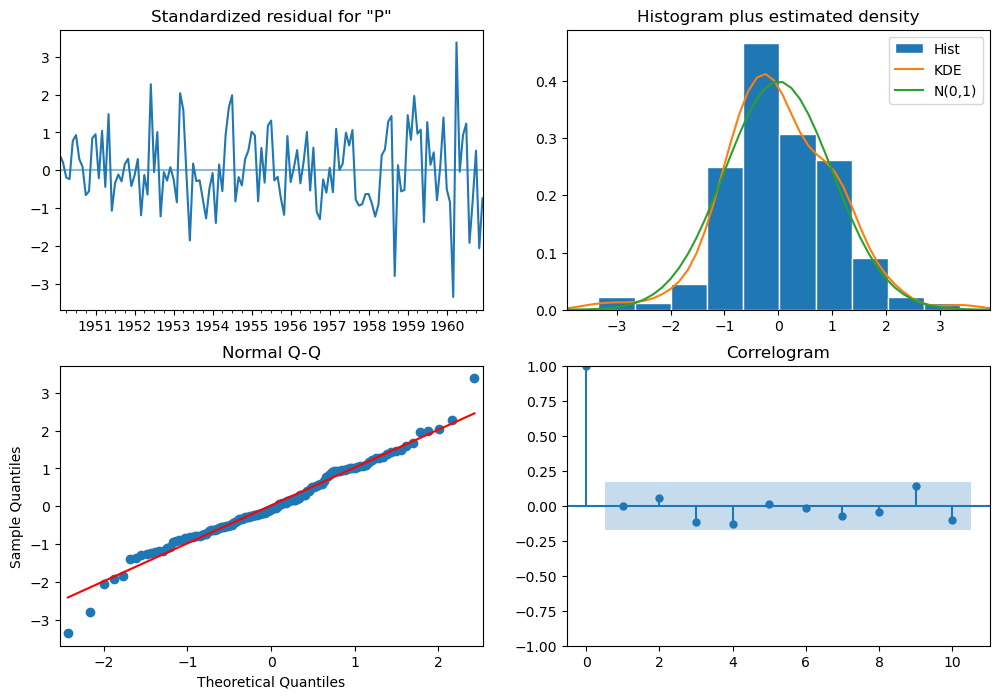

In [94]:
#Визуализация результатов
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Расшифровка визуализации
Кривая остатков — это график остатков модели по времени. Если модель хороша, остатки будут случайными, и график будет выглядеть как белый шум. 

График нормального квантиля (Q-Q plot) — это график, который сравнивает распределение остатков с идеальным нормальным распределением. Если точки следуют диагональной линии, это означает, что остатки нормально распределены.

График коррелограммы — это график автокорреляции остатков. Если модель хороша, остатки не будут коррелировать друг с другом. Отсутствие голубых полосок за пределами голубого диапазона шума указывает на это. 

Гистограмма остатков — это гистограмма распределения остатков. Если модель хороша, остатки должны быть нормально распределены, и эта гистограмма будет напоминать форму колокола. 

### Модель обучена

# Cтатистический прогноз
#get_prediction возвращает объект прогнозирования, из которого мы можем извлечь прогнозные значения при помощи predicted_mean:

In [96]:

start_date = pd.to_datetime('1955-12-01')
st_pred = results.get_prediction(start=start_date, dynamic=False) 
forecast_values = st_pred.predicted_mean

In [97]:
#будем использовать среднеквадратичную ошибку (MSE) как нашу метрику оценки точности прогноза:
actual_values = time_series[start_date:][global_source]
forecast_mse = ((forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка прогноза составляет {}'.format(round(forecast_mse, 2)))
#Чем ниже значение MSE, тем точнее модель.

Среднеквадратичная ошибка прогноза составляет 178.34


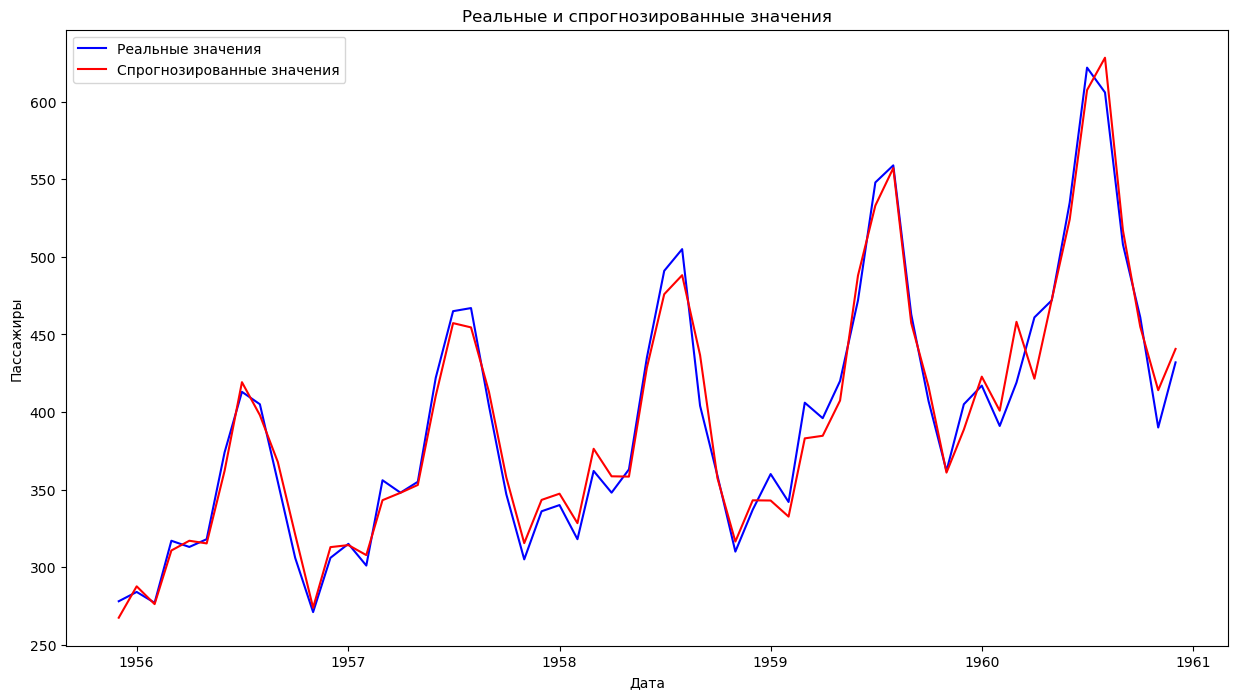

In [98]:
#визуализируем результаты
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(forecast_values.index, forecast_values, label='Спрогнозированные значения', color='red')

plt.title('Реальные и cпрогнозированные значения')
plt.xlabel('Дата')
plt.ylabel('Пассажиры')
plt.legend()

plt.show()

# Динамический прогноз
В статическом прогнозе модель использует весь известный набор данных для прогнозирования каждого следующего значения. Динамический прогноз начинает использовать самые свежие прогнозные значения для предсказания будущих значений, после определенной пользователем даты старта.

In [100]:
#меняем dynamic на True
start_date = pd.to_datetime('1955-12-01')
dyn_pred = results.get_prediction(start=start_date, dynamic=True) 
dynamic_forecast_values = dyn_pred.predicted_mean
#Рассчитываем среднеквадратичную ошибку для динамического прогноза
mse_dynamic_forecast = ((dynamic_forecast_values - actual_values) ** 2).mean()
print('Среднеквадратичная ошибка динамического прогноза составляет {}'.format(round(mse_dynamic_forecast, 2)))

Среднеквадратичная ошибка динамического прогноза составляет 677.11


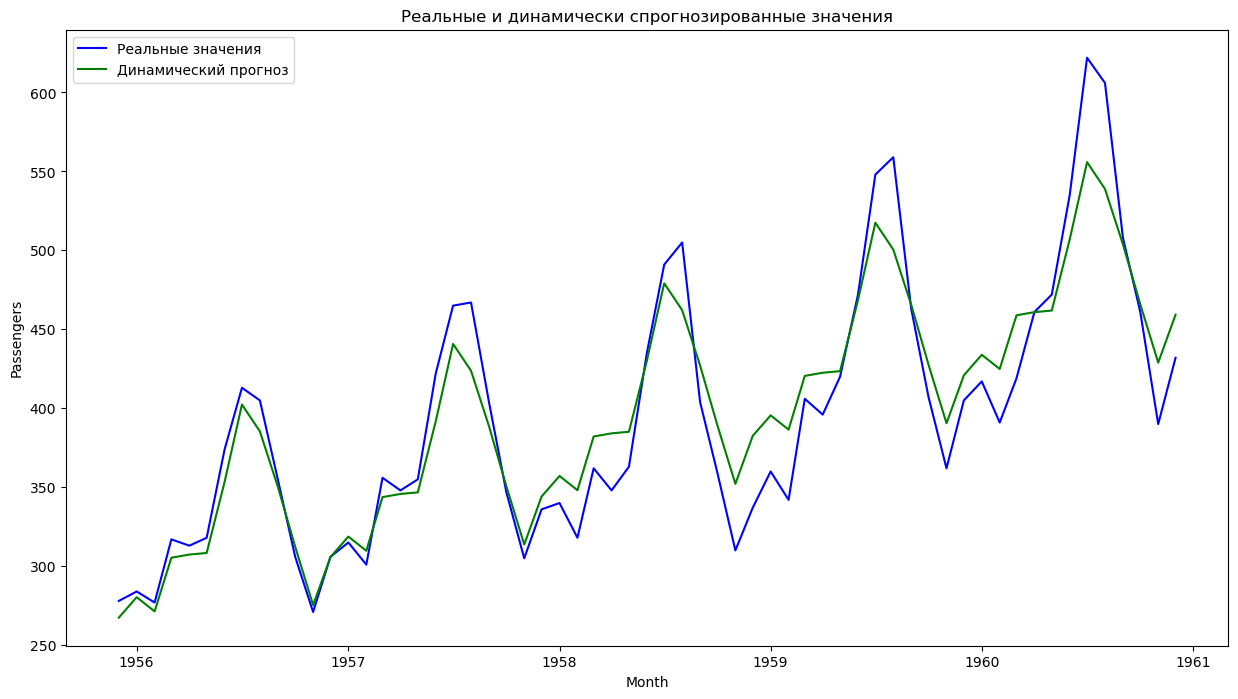

In [101]:
#Визуализируем график реальных и прогнозируемых значений
plt.figure(figsize=(15,8))

plt.plot(actual_values.index, actual_values, label='Реальные значения', color='blue')

plt.plot(dynamic_forecast_values.index, dynamic_forecast_values, label='Динамический прогноз', color='green')

plt.title('Реальные и динамически спрогнозированные значения')
plt.xlabel(global_date)
plt.ylabel(global_source)
plt.legend()

plt.show()

# Создание и визуализация прогноза БУДУЩЕГО

#Мы используем обученную модель (results) для получения прогноза на следующие 12 периодов времени. Поскольку наши данные содержали информацию до декабря 1960 года, здесь мы получим предсказание о количестве пассажиров каждый месяц на 1961 год. 
- Краткосрочные прогнозы: Обычно это 1-3 периода (дня, недели, месяца). Такие прогнозы, как правило, обладают высокой точностью. 
- Среднесрочные прогнозы: Обычно от 3 до 12 месяцев. Здесь точность может начать снижаться, но хорошие модели всё еще могут давать приемлемые результаты. 📈
- Долгосрочные прогнозы: 1-2 года и более. Точность сильно снижается из-за неопределенности изменений в данных, внешних факторов и влияния трендов. Однако, иногда можно использовать сценарный анализ для планирования.


In [102]:
pred_future = results.get_forecast(steps=30)

#Выведем средние прогнозируемые значения и доверительные интервалы:
print(f'Средние прогнозируемые значения:\n\n{pred_future.predicted_mean}')
print(f'\nДоверительные интервалы:\n\n{pred_future.conf_int()}')

Средние прогнозируемые значения:

1961-01-01    446.758368
1961-02-01    420.758368
1961-03-01    448.758368
1961-04-01    490.758368
1961-05-01    501.758368
1961-06-01    564.758368
1961-07-01    651.758368
1961-08-01    635.758368
1961-09-01    537.758368
1961-10-01    490.758368
1961-11-01    419.758368
1961-12-01    461.758368
1962-01-01    476.516737
1962-02-01    450.516737
1962-03-01    478.516737
1962-04-01    520.516737
1962-05-01    531.516737
1962-06-01    594.516737
1962-07-01    681.516737
1962-08-01    665.516737
1962-09-01    567.516737
1962-10-01    520.516737
1962-11-01    449.516737
1962-12-01    491.516737
1963-01-01    506.275105
1963-02-01    480.275105
1963-03-01    508.275105
1963-04-01    550.275105
1963-05-01    561.275105
1963-06-01    624.275105
Freq: MS, Name: predicted_mean, dtype: float64

Доверительные интервалы:

            lower Passengers  upper Passengers
1961-01-01        423.795376        469.721360
1961-02-01        392.969242        448.547495
1

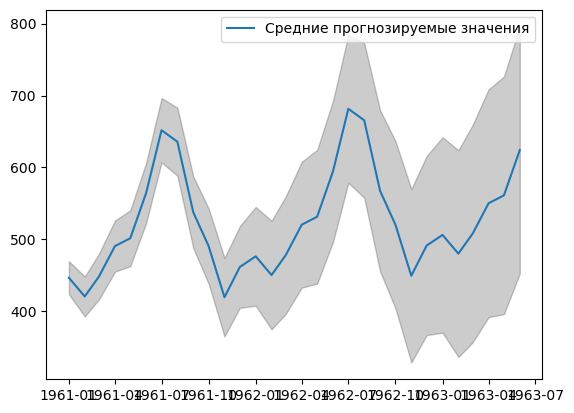

In [103]:
#Визуализация прогноза
fig = plt.figure()
plt.plot(pred_future.predicted_mean, label='Средние прогнозируемые значения')
plt.fill_between(pred_future.conf_int().index,
                 pred_future.conf_int().iloc[:, 0],
                 pred_future.conf_int().iloc[:, 1], color='k', alpha=.2)
plt.legend()  
plt.show()

Средние прогнозные значения показывают ожидаемое количество, а заполненная область вокруг прогноза представляет собой доверительный интервал.

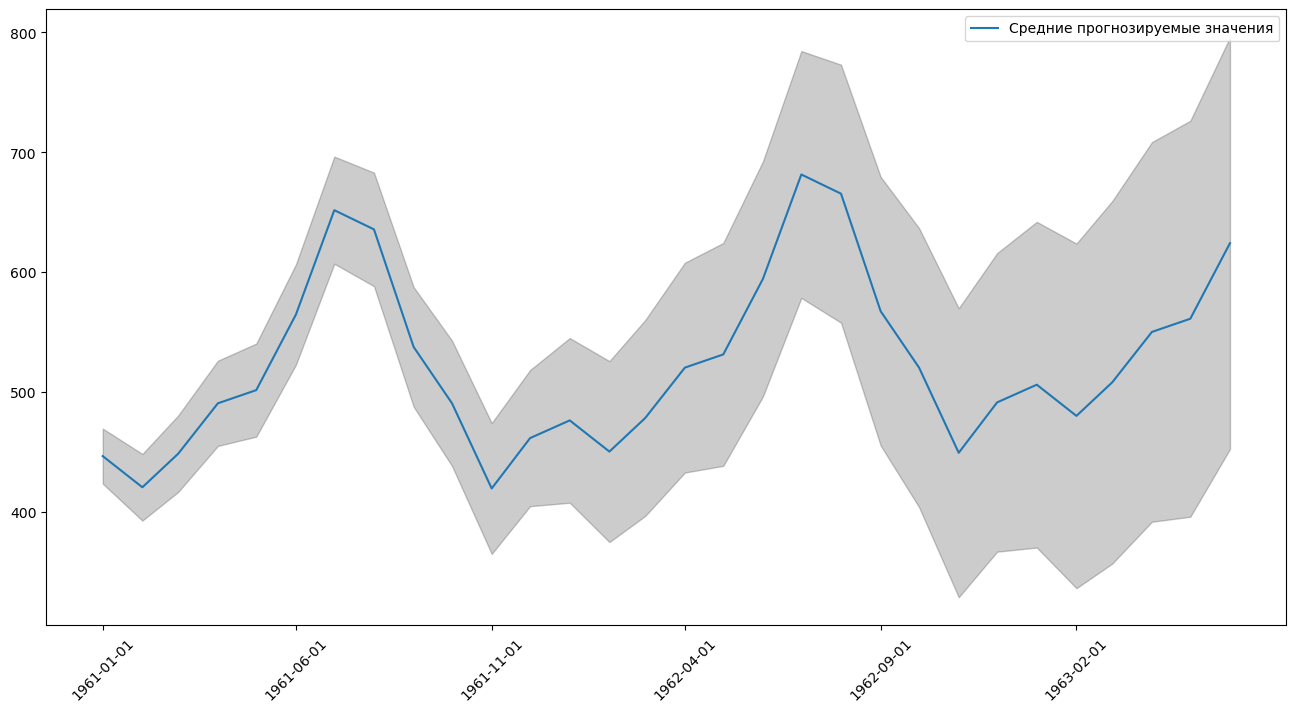

In [104]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(pred_future.predicted_mean.index, pred_future.predicted_mean, label='Средние прогнозируемые значения')
ax.fill_between(pred_future.conf_int().index,
                pred_future.conf_int().iloc[:, 0],
                pred_future.conf_int().iloc[:, 1], color='k', alpha=.2)

# Установка меток оси X
if isinstance(pred_future.predicted_mean.index, pd.DatetimeIndex):
    ax.set_xticks(pred_future.predicted_mean.index[::5])  # Например, каждый 5-й элемент
    ax.set_xticklabels(pred_future.predicted_mean.index[::5].strftime('%Y-%m-%d'), rotation=45)
else:
    # Если индекс не временной, просто используйте его как есть
    ax.set_xticks(pred_future.predicted_mean.index[::5])
    ax.set_xticklabels(pred_future.predicted_mean.index[::5], rotation=45)

ax.legend()  
plt.show()